In [1]:
import geopandas as gpd
import pandas as pd
import json
from folium.features import GeoJsonTooltip
import folium
import random
import branca

   id               Nome  Código do  IBGE  Código do  Bairro  Área (ha)  \
0  77  Rachel de Queiroz       2304400077                 77     196.88   
1  23     José Bonifácio       2304400023                 23      88.90   
2  40    Antônio Bezerra       2304400040                 40     219.69   
3  44            Genibaú       2304400044                 44     215.80   
4  57      Edson Queiroz       2304400057                 57    1384.82   

  Regional Antiga                    Regional Atual Código da  Região  \
0          SER IV   Secretaria Executiva Regional 8                VI   
1          SER IV   Secretaria Executiva Regional 4                 V   
2         SER III   Secretaria Executiva Regional 3                IV   
3           SER V  Secretaria Executiva Regional 11                XI   
4          SER VI   Secretaria Executiva Regional 7               VII   

   Território     Fonte  ano_ref       data  \
0          19  IPLANFOR     2019 2022-11-13   
1          15  I

<Axes: >

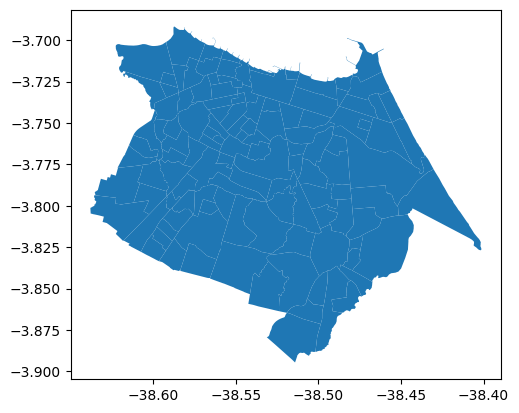

In [2]:
gdf = gpd.read_file("source_data/geo.json")
print(gdf.head())
gdf.plot()

In [3]:
gdf["data"] = gdf["data"].astype(str)

##### **1. Bairros por AIS**

In [4]:
with open('source_data/bairros_por_ais.json', 'r') as file:
    bairros_por_ais = json.load(file)


bairro_para_ais = {}
for ais, bairros in bairros_por_ais.items():
    for bairro in bairros:
        bairro_para_ais[bairro] = ais

gdf["AIS"] = gdf["Nome"].map(bairro_para_ais)

gdf = gdf.dropna(subset=["AIS"])

##### **2.1 Adicionar dados de densidade populacional**

In [5]:
with open('source_data/densidade_populacional_2022.json', 'r') as file:
    densidade_populacional_2022 = json.load(file)

gdf["Densidade"] = gdf["Nome"].map(densidade_populacional_2022)

##### **2.2 Adicionar dados de população**

In [6]:
with open('source_data/populacao_2022.json', 'r') as file:
    populacao_2022 = json.load(file)

gdf["População"] = gdf["Nome"].map(populacao_2022)

##### **2.3 Adicionar dados de crimes**

In [7]:
with open('source_data/crimes_por_ais.json', 'r') as file:
    crimes_por_ais = json.load(file)

gdf["Crimes"] = gdf["AIS"].map(crimes_por_ais)

##### **2.4 Taxa de crimes por 1000 hab.**

In [8]:
gdf['Taxa_Crimes'] = (gdf['Crimes'] / gdf['População']) * 1000

##### **3. Modelos de mapas**

##### **3.1. Mapa inicial**

In [9]:
def random_pastel_color():
    r = lambda: random.randint(100, 255)
    return f'#{r():02x}{r():02x}{r():02x}'

ais_list = sorted(gdf["AIS"].unique())
ais_colors = {ais: random_pastel_color() for ais in ais_list}

gdf_proj = gdf.to_crs("EPSG:31984")

# Calcula o centro médio do mapa em metros
centroid_mean = gdf_proj.geometry.centroid.union_all().centroid

# Transforma de volta para WGS84 (EPSG:4326) para usar no folium
centroid_wgs84 = gpd.GeoSeries([centroid_mean], crs="EPSG:31984").to_crs("EPSG:4326").geometry[0]

# Usa no folium
m = folium.Map(location=[centroid_wgs84.y, centroid_wgs84.x], zoom_start=12)

# Função de estilo por AIS
def style_function(feature):
    ais = feature["properties"]["AIS"]
    return {
        "fillOpacity": 0.5,
        "weight": 0.8,
        "color": "black",
        "fillColor": ais_colors.get(ais, "#cccccc")
    }

# Tooltip com nome e AIS
tooltip = folium.GeoJsonTooltip(
    fields=["Nome", "AIS", "População", "Densidade", "Crimes", "Taxa_Crimes"],
    aliases=["Bairro:", "AIS:", "População:", "Densidade pop.(hab/km²):", "Crimes:", "Crimes (por mil hab):"],
    localize=True
)

# Adicionar camada ao mapa
folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=tooltip,
    name="Bairros por AIS"
).add_to(m)

folium.LayerControl().add_to(m)
m.save("mapas/mapa_base_interativo.html")
m


##### **3.2. População por bairros**

In [10]:
ais_list = sorted(gdf["AIS"].unique())

gdf_proj = gdf.to_crs("EPSG:31984")

centroid_mean = gdf_proj.geometry.centroid.union_all().centroid
centroid_wgs84 = gpd.GeoSeries([centroid_mean], crs="EPSG:31984").to_crs("EPSG:4326").geometry[0]


m = folium.Map(location=[centroid_wgs84.y, centroid_wgs84.x], zoom_start=12)

colormap = branca.colormap.linear.YlOrRd_09.scale(
    gdf["População"].min(), gdf["População"].max()
)
colormap = colormap.to_step(index=[10_000, 20_000, 30_000, 40_000, 50_000])
colormap.caption = "População (hab)"

def style_function(feature):
    populacao = feature["properties"].get("População")
    color = colormap(populacao) if populacao is not None else "#cccccc"
    return {
        "fillColor": color,
        "color": "black",  # contorno dos bairros
        "weight": 0.5,
        "fillOpacity": 0.6,  # transparência
    }

tooltip = folium.GeoJsonTooltip(
    fields=["Nome", "AIS", "População", "Densidade", "Crimes", "Taxa_Crimes"],
    aliases=["Bairro:", "AIS:", "População (hab):", "Densidade pop. (hab/km²):",  "Crimes:", "Crimes por 1000 hab.:"],
    localize=True
)

folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=tooltip,
    name="Bairros por AIS e População"
).add_to(m)

colormap.add_to(m)
folium.LayerControl().add_to(m)

# Adiciona título
title_html = '''
    <h3 style="position:fixed;top:10px;left:50px;z-index:1000;background-color:white;padding:10px;border-radius:5px;box-shadow:0 0 5px rgba(0,0,0,0.2)">
    Fortaleza - População por Bairros</h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

m.save("mapas/população_por_bairros.html")
m


##### **3.3. População por AIS**

In [11]:
ais_population = gdf.groupby('AIS')['População'].sum().to_dict()
ais_crimes = gdf.groupby('AIS')['Crimes'].sum().to_dict()
gdf['AIS_População'] = gdf['AIS'].map(ais_population)
gdf['AIS_Crimes'] = gdf['AIS'].map(ais_crimes)
gdf['Taxa_Crimes_AIS'] = (gdf['AIS_Crimes'] / gdf['AIS_População']) * 1000

centroid = gdf.to_crs("EPSG:31984").geometry.centroid.union_all().centroid
centroid_wgs84 = gpd.GeoSeries([centroid], crs="EPSG:31984").to_crs("EPSG:4326").geometry[0]
m = folium.Map(location=[centroid_wgs84.y, centroid_wgs84.x], zoom_start=12)

# Configuração do colormap para população
colormap = branca.colormap.linear.YlOrRd_09.scale(
    min(ais_population.values()),
    max(ais_population.values())
).to_step(index=[50_000, 100_000, 150_000, 200_00, 250_000, 300_000, 350_000])

colormap.caption = "População Total por AIS (hab)"
colormap.add_to(m)


random.seed(42)
ais_border_colors = {ais: "#{:06x}".format(random.randint(0, 0xFFFFFF)) for ais in ais_population.keys()}

# Estilo dos bairros (coloridos por população da AIS)
def style_function(feature):
    ais = feature['properties']['AIS']
    ais_pop = ais_population.get(ais, 0)
    return {
        "fillColor": colormap(ais_pop),
        "color": "#333333",
        "weight": 0.5,
        "fillOpacity": 0.7,
    }

# Estilo das bordas das AIS
def border_style(feature):
    ais = feature['properties']['AIS']
    return {
        "color": ais_border_colors[ais],
        "weight": 2.5,
        "fillOpacity": 0,
        "dashArray": "5, 5"
    }

tooltip = GeoJsonTooltip(
    fields=["Nome", "AIS", "População", "Densidade", "AIS_População", "AIS_Crimes", "Taxa_Crimes_AIS"],
    aliases=[
        "Bairro:", 
        "AIS:", 
        "População (hab):", 
        "Densidade (hab/km²):",
        "População da AIS:", 
        "Crimes na AIS:", 
        "Taxa Crimes AIS (por mil):"
    ],
    localize=True,
    style=("""
        background-color: white;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px 3px;
    """),
    formatter=".2f"
)

folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=tooltip,
    name="Bairros (coloridos por população da AIS)"
).add_to(m)

# Cria limites das AIS dissolvidos
ais_boundaries = gdf.dissolve(by="AIS").reset_index()

folium.GeoJson(
    ais_boundaries,
    style_function=border_style,
    name="Limites das AIS",
    show=False
).add_to(m)

folium.LayerControl().add_to(m)

# Adiciona título
title_html = '''
    <h3 style="position:fixed;top:10px;left:50px;z-index:1000;background-color:white;padding:10px;border-radius:5px;box-shadow:0 0 5px rgba(0,0,0,0.2)">
    Fortaleza - Bairros x população das AIS</h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

m.save("mapas/população_por_ais.html")
m

##### **3.4. Crimes por AIS**

In [12]:
crimes_por_ais = gdf.groupby("AIS")["Crimes"].sum().to_dict()

gdf["Total_Crimes_AIS"] = gdf["AIS"].map(crimes_por_ais)

class_bins = [min(crimes_por_ais.values()),
              sorted(crimes_por_ais.values())[len(crimes_por_ais)//3],
              sorted(crimes_por_ais.values())[2*len(crimes_por_ais)//3],
              max(crimes_por_ais.values())]

gdf_proj = gdf.to_crs("EPSG:31984")
centroid_mean = gdf_proj.geometry.centroid.union_all().centroid
centroid_wgs84 = gpd.GeoSeries([centroid_mean], crs="EPSG:31984").to_crs("EPSG:4326").geometry[0]
m = folium.Map(location=[centroid_wgs84.y, centroid_wgs84.x], zoom_start=12)

colormap = branca.colormap.linear.YlOrRd_09.scale(
    min(crimes_por_ais.values()),
    max(crimes_por_ais.values())
).to_step(index=class_bins)
colormap.caption = "Número de Crimes por AIS"

def style_function(feature):
    crimes = feature["properties"].get("Total_Crimes_AIS")
    if crimes is None or pd.isna(crimes):
        return {
            "fillColor": "#cccccc",
            "color": "black",
            "weight": 0.5,
            "fillOpacity": 0.6,
            "dashArray": "5, 5"
        }
    return {
        "fillColor": colormap(crimes),
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.8,
    }


tooltip = folium.GeoJsonTooltip(
    fields=["Nome", "AIS", "Crimes", "População", "Densidade"],
    aliases=["Bairro:", "AIS:", "Crimes:", "População (hab):", "Densidade pop. (hab/km²):"],
    localize=True
)

folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=tooltip,
    name="Bairros por AIS e Crimes"
).add_to(m)

colormap.add_to(m)
folium.LayerControl().add_to(m)

title_html = '''
    <h3 style="position:fixed;top:10px;left:50px;z-index:1000;background-color:white;padding:10px;border-radius:5px;box-shadow:0 0 5px rgba(0,0,0,0.2)">
    Fortaleza - Crimes x AIS</h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

m.save("mapas/crimes_por_ais.html")
m

##### **3.5. Taxa de crimes por 1000 hab.**

In [13]:
gdf_proj = gdf.to_crs("EPSG:31984")

centroid_mean = gdf_proj.geometry.centroid.union_all().centroid
centroid_wgs84 = gpd.GeoSeries([centroid_mean], crs="EPSG:31984").to_crs("EPSG:4326").geometry[0]

m = folium.Map(location=[centroid_wgs84.y, centroid_wgs84.x], zoom_start=12)

colormap = branca.colormap.linear.YlOrRd_09.scale(
    gdf["Taxa_Crimes"].min(), 
    gdf["Taxa_Crimes"].max()
)
colormap = colormap.to_step(index=[25, 50, 75, 100, 125, 150])
colormap.caption = "Taxa de Crimes (por mil hab.)"

def style_function(feature):
    taxa = feature["properties"].get("Taxa_Crimes")
    color = colormap(taxa) if taxa is not None else "#cccccc"
    return {
        "fillColor": color,
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.7,
    }

tooltip = folium.GeoJsonTooltip(
    fields=["Nome", "AIS", "População", "Crimes", "Taxa_Crimes"],
    aliases=["Bairro:", "AIS:", "População (hab):", "Total Crimes:", "Crimes (por mil hab):"],
    localize=True,
    formatter="{0:.2f}",
)

folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=tooltip,
    name="Taxa de Crimes por Bairro"
).add_to(m)

colormap.add_to(m)

folium.LayerControl().add_to(m)

title_html = '''
    <h3 style="position:fixed;top:10px;left:50px;z-index:1000;background-color:white;padding:10px;border-radius:5px;box-shadow:0 0 5px rgba(0,0,0,0.2)">
    Fortaleza - Bairros x Taxas de Crimes (por 1000 hab.)</h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

m.save("mapas/taxa_crimes_por_populacao.html")
m